In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, linregress

Prepare flux data


In [5]:
ec = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/AMF_US-Ha1_FLUXNET_SUBSET_WW_1991-2020_3-5.csv"
)

ec["t1"] = pd.to_datetime(ec["TIMESTAMP_START"], format="%Y%m%d")
ec["t2"] = pd.to_datetime(ec["TIMESTAMP_END"], format="%Y%m%d")


Prepare MODIS data FPAR


In [6]:
fpar = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha1-MYD15A2H-061-results.csv"
)
# filter based on QC flags
filtered_fpar = fpar[
    (fpar["MYD15A2H_061_FparLai_QC_MODLAND"] == "0b0")
    & (fpar["MYD15A2H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (fpar["MYD15A2H_061_FparLai_QC_CloudState"] == "0b00")
    & (fpar["MYD15A2H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
]
filtered_fpar["time"] = pd.to_datetime(filtered_fpar["Date"])

/tmp/ipykernel_341815/2160639896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fpar["time"] = pd.to_datetime(filtered_fpar["Date"])


In [7]:
refl = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha-brdf-reflec-MCD43A4-061-results.csv"
)
# filter based on QC flags
filtered_refl = refl[
    (refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"] == "0b000")
    & (refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"] == "0b000")
]
filtered_refl["time"] = pd.to_datetime(filtered_refl["Date"])
filtered_refl

/tmp/ipykernel_341815/778562896.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_refl["time"] = pd.to_datetime(filtered_refl["Date"])


,Category,ID,Latitude,Longitude,Date,MODIS_Tile,MCD43A4_061_Line_Y_500m,MCD43A4_061_Sample_X_500m,MCD43A4_061_Nadir_Reflectance_Band1,MCD43A4_061_Nadir_Reflectance_Band2,...,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_MODLAND,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_MODLAND_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_Fill,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_Fill_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_bitmask,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_MODLAND,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_MODLAND_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_Fill,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_Fill_Description,time
0,DBF,US-Ha1,42.5378,-72.1715,2002-01-01,h12v04,1790.0,1637.0,0.0340,0.1797,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-01
1,DBF,US-Ha1,42.5378,-72.1715,2002-01-02,h12v04,1790.0,1637.0,0.0342,0.1800,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-02
2,DBF,US-Ha1,42.5378,-72.1715,2002-01-03,h12v04,1790.0,1637.0,0.0341,0.1801,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-03
94,DBF,US-Ha1,42.5378,-72.1715,2002-04-05,h12v04,1790.0,1637.0,0.0432,0.2039,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-04-05
95,DBF,US-Ha1,42.5378,-72.1715,2002-04-06,h12v04,1790.0,1637.0,0.0435,0.2045,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7992,DBF,US-Ha1,42.5378,-72.1715,2023-11-20,h12v04,1790.0,1637.0,0.0400,0.1686,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-20
7993,DBF,US-Ha1,42.5378,-72.1715,2023-11-21,h12v04,1790.0,1637.0,0.0347,0.1454,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-21
7994,DBF,US-Ha1,42.5378,-72.1715,2023-11-22,h12v04,1790.0,1637.0,0.0346,0.1451,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-22
7995,DBF,US-Ha1,42.5378,-72.1715,2023-11-23,h12v04,1790.0,1637.0,0.0343,0.1456,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-23


In [8]:
refl_data_weekly = pd.DataFrame()

for index, ec_row in ec.iterrows():
    start_date = ec["t1"][index]
    end_date = ec["t2"][index]

    # Filter refl data
    mask_refl = (filtered_refl["time"] >= start_date) & (
        filtered_refl["time"] <= end_date
    )

    refl_within_week = filtered_refl[mask_refl]

    # Calculate the mean of MCD43A4_061_Nadir_Reflectance_Band1 for the week
    b1_mean = refl_within_week["MCD43A4_061_Nadir_Reflectance_Band1"].median()

    # Calculate the mean of MCD43A4_061_Nadir_Reflectance_Band2 for the week
    b2_mean = refl_within_week["MCD43A4_061_Nadir_Reflectance_Band2"].median()

    # Create a DataFrame with the calculated mean values
    weekly_means_df = pd.DataFrame(
        {
            "MCD43A4_061_Nadir_Reflectance_Band1_mean": [b1_mean],
            "MCD43A4_061_Nadir_Reflectance_Band2_mean": [b2_mean],
        }
    )

    # Append the mean refl data to 'refl_data_weekly'
    refl_data_weekly = pd.concat([refl_data_weekly, weekly_means_df], ignore_index=True)

refl_data_weekly["t1"] = ec["t1"].values
refl_data_weekly["t2"] = ec["t2"].values

In [9]:
selected_fpar_data = pd.DataFrame()
selected_ec_data = pd.DataFrame()
selected_refl_data = pd.DataFrame()
for index, ec_row in ec.iterrows():
    start_date = ec["t1"][index]
    end_date = ec["t2"][index]
    mask_fpar = (filtered_fpar["time"] >= start_date) & (
        filtered_fpar["time"] <= end_date
    )
    if (mask_fpar == True).any():
        fpar_within_week = filtered_fpar[mask_fpar]
        selected_fpar_data = pd.concat([selected_fpar_data, fpar_within_week])
        selected_ec_data = pd.concat([selected_ec_data, ec.iloc[[index]]])
        selected_refl_data = pd.concat(
            [selected_refl_data, refl_data_weekly.iloc[[index]]]
        )

In [10]:
selected_fpar_data["t1"] = selected_ec_data["t1"].values
selected_fpar_data["t2"] = selected_ec_data["t2"].values

In [11]:
selected_ec_data_filtered = selected_ec_data[
    (selected_ec_data["t1"].dt.month >= 6)
    & (selected_ec_data["t1"].dt.month <= 8)
    & (selected_ec_data["t2"].dt.month >= 6)
    & (selected_ec_data["t2"].dt.month <= 8)
]
selected_fpar_data_filtered = selected_fpar_data[
    (selected_fpar_data["t1"].dt.month >= 6)
    & (selected_fpar_data["t1"].dt.month <= 8)
    & (selected_fpar_data["t2"].dt.month >= 6)
    & (selected_fpar_data["t2"].dt.month <= 8)
]
selected_refl_data_filtered = refl_data_weekly[
    (refl_data_weekly["t1"].dt.month >= 6)
    & (refl_data_weekly["t1"].dt.month <= 8)
    & (refl_data_weekly["t2"].dt.month >= 6)
    & (refl_data_weekly["t2"].dt.month <= 8)
]

In [12]:
selected_ec_data["year"] = pd.to_datetime(selected_ec_data["t1"]).dt.year
red = selected_refl_data[["t1", "t2", "MCD43A4_061_Nadir_Reflectance_Band1_mean"]]
nir = selected_refl_data[["t1", "t2", "MCD43A4_061_Nadir_Reflectance_Band2_mean"]]
fpar = selected_fpar_data[["t1", "t2", "MYD15A2H_061_Fpar_500m"]]
red["year"] = pd.to_datetime(red["t1"]).dt.year
nir["year"] = pd.to_datetime(nir["t1"]).dt.year
fpar["year"] = pd.to_datetime(fpar["t1"]).dt.year

# Group by 'year' and find the min and max 'GPP_NT_VUT_REF'
annual_min_max_gpp = selected_ec_data.groupby("year")["GPP_NT_VUT_REF"].agg(
    ["min", "max"]
)
annual_min_max_red = red.groupby("year")[
    "MCD43A4_061_Nadir_Reflectance_Band1_mean"
].agg(["min", "max"])
annual_min_max_nir = nir.groupby("year")[
    "MCD43A4_061_Nadir_Reflectance_Band2_mean"
].agg(["min", "max"])
annual_min_max_fpar = fpar.groupby("year")["MYD15A2H_061_Fpar_500m"].agg(["min", "max"])

/tmp/ipykernel_341815/4101552274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpar["year"] = pd.to_datetime(fpar["t1"]).dt.year


In [13]:
gpp = selected_ec_data["GPP_NT_VUT_REF"].values
par = selected_ec_data["PPFD_IN"].values
fpar = selected_fpar_data["MYD15A2H_061_Fpar_500m"].values
red = selected_refl_data["MCD43A4_061_Nadir_Reflectance_Band1_mean"].values
nir = selected_refl_data["MCD43A4_061_Nadir_Reflectance_Band2_mean"].values
selected_refl_data["NDVI"] = (nir - red) / (nir + red)
selected_refl_data["year"] = pd.to_datetime(selected_refl_data["t1"]).dt.year
annual_min_max_ndvi = selected_refl_data.groupby("year")["NDVI"].agg(["min", "max"])

# ndvi = (nir - red) / (nir + red)
# fesc = (ndvi * nir) / fpar
# lue = gpp / (fpar * par)

In [17]:
gpp = selected_ec_data["GPP_NT_VUT_REF"].values
par = selected_ec_data["PPFD_IN"].values
fpar = selected_fpar_data["MYD15A2H_061_Fpar_500m"].values
red = selected_refl_data["MCD43A4_061_Nadir_Reflectance_Band1_mean"].values
nir = selected_refl_data["MCD43A4_061_Nadir_Reflectance_Band2_mean"].values

# ndvi = (nir - red) / (nir + red)
# fesc = (ndvi * nir) / fpar
# lue = gpp / (fpar * par)

In [18]:
# Find indices of non-NaN values in red and nir arrays
valid_indices = np.logical_and(~np.isnan(red), ~np.isnan(nir))
# # Select gpp, par, and fpar values for valid indices
valid_gpp = gpp[valid_indices]
valid_par = par[valid_indices]
valid_fpar = fpar[valid_indices]
valid_nir = nir[valid_indices]
valid_red = red[valid_indices]

ndvi = (valid_nir - valid_red) / (valid_nir + valid_red)
fesc = (ndvi * valid_nir) / valid_fpar
lue = valid_gpp / (valid_fpar * valid_par)

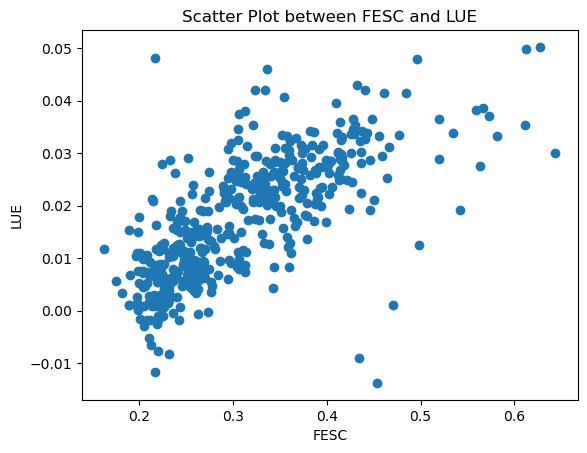

R-squared: 0.5118610669387166


In [19]:
# Combine FESC and LUE into a single DataFrame
scatter_data = pd.DataFrame({"FESC": fesc, "LUE": lue})

# Remove outliers using z-score
z_scores = zscore(scatter_data)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)  # Adjust the threshold as needed
filtered_data = scatter_data[filtered_entries]

# Create a scatter plot
plt.scatter(filtered_data["FESC"], filtered_data["LUE"])
plt.xlabel("FESC")
plt.ylabel("LUE")
plt.title("Scatter Plot between FESC and LUE")
plt.show()

# Calculate R-squared
slope, intercept, r_value, p_value, std_err = linregress(
    filtered_data["FESC"], filtered_data["LUE"]
)
r_squared = r_value**2
print(f"R-squared: {r_squared}")

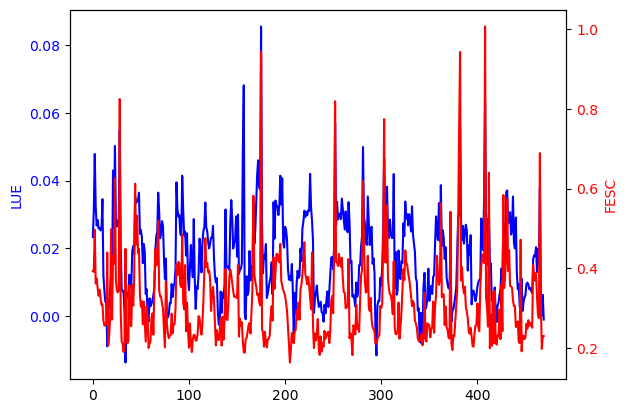

In [58]:
# Create a figure and a subplot (axis)
fig, ax1 = plt.subplots()

# Plot 'lue' on the first axis
ax1.plot(lue, color="blue")
ax1.set_ylabel("LUE", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot 'fesc' on the second axis
ax2.plot(fesc, color="red")
ax2.set_ylabel("FESC", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Display the plot
plt.show()

In [ ]:
gpp = selected_ec_data_filtered["GPP_NT_VUT_REF"].values
par = selected_ec_data_filtered["PPFD_IN"].values
fpar = selected_fpar_data_filtered["MYD15A2H_061_Fpar_500m"].values
red = selected_refl_data_filtered["MYD09A1_061_sur_refl_b01"].values
nir = selected_refl_data_filtered["MYD09A1_061_sur_refl_b02"].values
ndvi = (nir - red) / (nir + red)
fesc = (ndvi * nir) / fpar
lue = gpp / (fpar * par)

In [ ]:
# Combine FESC and LUE into a single DataFrame
scatter_data = pd.DataFrame({"FESC": fesc, "LUE": lue})

# Remove outliers using z-score
z_scores = zscore(scatter_data)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)  # Adjust the threshold as needed
filtered_data = scatter_data[filtered_entries]

# Create a scatter plot
plt.scatter(filtered_data["FESC"], filtered_data["LUE"])
plt.xlabel("FESC")
plt.ylabel("LUE")
plt.title("Scatter Plot between FESC and LUE")
plt.show()

# Calculate R-squared
slope, intercept, r_value, p_value, std_err = linregress(
    filtered_data["FESC"], filtered_data["LUE"]
)
r_squared = r_value**2
print(f"R-squared: {r_squared}")

In [ ]:
# Create a figure and a subplot (axis)
fig, ax1 = plt.subplots()

# Plot 'lue' on the first axis
ax1.plot(lue, color="blue")
ax1.set_ylabel("LUE", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot 'fesc' on the second axis
ax2.plot(fesc, color="red")
ax2.set_ylabel("FESC", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Display the plot
plt.show()